<h1>CV Project: Lidar Clustering</h1>

# Description
We are given a set of Lidar and RGB images images, we are formally asked to segment the cluster of lidar.

# Import, load repo and set seeds

In [5]:
import os
import numpy as np
import torch
import cv2
import pytorch_lightning as pl
from glob import glob
from torch import nn
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [6]:
# Set seeds
torch.manual_seed(420)
np.random.seed(420)

In [7]:
# Define Constants
IMG_SHAPE = (512, 1392)

# Load Paths

In [4]:
base_path = "./dataset"
test_path = base_path + "/test/images"
train_path = base_path + "/train"
data_paths = sorted([f"{base_path}/images/{x}" for x in os.listdir(f"{base_path}/images/")])[:100]
label_paths = sorted([f"{base_path}/groundtruth/{x}" for x in os.listdir(f"{base_path}/groundtruth/")])[:100]
data_paths_val = sorted([f"{base_path}/val_images/{x}" for x in os.listdir(f"{base_path}/val_images/")])
label_paths_val = sorted([f"{base_path}/val_groundtruth/{x}" for x in os.listdir(f"{base_path}/val_groundtruth/")])
test_paths = sorted([f"{test_path}/{x}" for x in os.listdir(test_path)])

In [5]:
from itertools import product

perm = list(product(range(IMG_SHAPE[0]//PATCH_SIZE[0]), range(IMG_SHAPE[1]//PATCH_SIZE[1])))
data_paths = [(path,) + index for index in perm for path in data_paths]
label_paths = [path for index in perm for path in label_paths]
data_paths_val = [(path,) + index for index in perm for path in data_paths_val]
label_paths_val = [path for index in perm for path in label_paths_val]

In [6]:
""" print(data_paths)
print(label_paths) """

[('./dataset_CIL_road_seg_big/images/10078660_150_dataset_road_seg_cil_2023.png', 0, 0), ('./dataset_CIL_road_seg_big/images/10078660_1512_dataset_road_seg_cil_2023.png', 0, 0), ('./dataset_CIL_road_seg_big/images/10078660_1513_dataset_road_seg_cil_2023.png', 0, 0), ('./dataset_CIL_road_seg_big/images/10078660_151_dataset_road_seg_cil_2023.png', 0, 0), ('./dataset_CIL_road_seg_big/images/10078660_154_dataset_road_seg_cil_2023.png', 0, 0), ('./dataset_CIL_road_seg_big/images/10078660_155_dataset_road_seg_cil_2023.png', 0, 0), ('./dataset_CIL_road_seg_big/images/10078660_158_dataset_road_seg_cil_2023.png', 0, 0), ('./dataset_CIL_road_seg_big/images/10078660_159_dataset_road_seg_cil_2023.png', 0, 0), ('./dataset_CIL_road_seg_big/images/10078675_150_dataset_road_seg_cil_2023.png', 0, 0), ('./dataset_CIL_road_seg_big/images/10078675_1510_dataset_road_seg_cil_2023.png', 0, 0), ('./dataset_CIL_road_seg_big/images/10078675_1511_dataset_road_seg_cil_2023.png', 0, 0), ('./dataset_CIL_road_seg_bi

In [7]:
# Split data into validation and train
#data_paths, data_paths_val, label_paths, label_paths_val = train_test_split(data_paths, label_paths, test_size=0.2)

# Set Transforms

In [8]:
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from utils.transforms import rgb_to_gray, equalize_hist, transform_default, lbl_for_patch
# Define needed transformation we want to apply on the data

patchwise_label1 = lbl_for_patch((80, 80), IMG_SHAPE, road_percentage=0.04)
patchwise_label2 = lbl_for_patch((16, 16), IMG_SHAPE, road_percentage=0.00001)

#transf = transforms.Compose([rgb_to_gray, equalize_hist, transform_default])
data_transf = transforms.Compose([
    transforms.Lambda(lambda t: cv2.resize(t, IMG_SHAPE)), 
    transform_default
])
label_transf1 = transforms.Compose([
    rgb_to_gray, 
    transforms.Lambda(lambda t: cv2.resize(t, IMG_SHAPE)), 
    transform_default, 
    #transforms.Lambda(lambda t: patchwise_label1(t.squeeze()).squeeze()),
    #transforms.Lambda(lambda t: t.view((1, 5, 5))),
    #transforms.Resize(IMG_SHAPE, interpolation=InterpolationMode.NEAREST)
])
label_transf2 = transforms.Compose([
    rgb_to_gray, 
    transforms.Lambda(lambda t: cv2.resize(t, IMG_SHAPE)), 
    transform_default, 
    transforms.Lambda(lambda t: patchwise_label2(t.squeeze()).squeeze())
])

# Training Preparation

In [9]:
BATCH_SIZE = 16
EPOCHS = 5

In [10]:
from utils.datasets import AllInOneDataset

train_dataset = AllInOneDataset(data_paths, label_paths, patch_size=PATCH_SIZE, data_transform=data_transf, label_transform=label_transf1)#, extra_layers_transf=[label_transf1])
val_dataset = AllInOneDataset(data_paths_val, label_paths_val, patch_size=PATCH_SIZE, data_transform=data_transf, label_transform=label_transf1)#, extra_layers_transf=[label_transf1])

In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [12]:
from torchvision.models import efficientnet_v2_s
from sklearn.metrics import accuracy_score
from models.convnet import ConvNet
from models.unet import UNet
# Import the models and the necessary loss
metric = accuracy_score
loss_fct = torch.nn.BCELoss()
unet = UNet(loss=loss_fct, eval_metric=metric, channels=3, f=48, img_shape=IMG_SHAPE, activate_clf=False)
model = unet
#model = ConvNet(unet, loss=loss_fct, eval_metric=metric, input_channels=3, output_layers=25, optimizer=torch.optim.Adam, lr=1e-4)
#model = ConvNet(unet, loss=loss_fct, eval_metric=metric, input_channels=3, output_layers=25, optimizer=torch.optim.Adam, lr=1e-4)

# Training Loop

In [13]:
#trainer = pl.Trainer(accelerator="cpu", max_epochs=5)
#trainer.fit(model, train_loader, val_loader)

In [14]:
#torch.save(model.state_dict(), 'weights.pt')

In [15]:
model.load_state_dict(torch.load("weights/unetweightsnewdata.pt"))

<All keys matched successfully>

In [16]:
postprocess = lbl_for_patch((16, 16), IMG_SHAPE, road_percentage=0.25)

post = transforms.Compose([
    rgb_to_gray, 
    transforms.Lambda(lambda t: cv2.resize(t, IMG_SHAPE)), 
    transform_default, 
    transforms.Lambda(lambda t: postprocess(t.squeeze()).squeeze()),
])

./dataset_CIL_road_seg_big/val_images/satimage_0_dataset_eth.png
./dataset_CIL_road_seg_big/val_groundtruth/satimage_0_dataset_eth.png
torch.Size([3, 400, 400])
./dataset_CIL_road_seg_big/val_images/satimage_100_dataset_eth.png
./dataset_CIL_road_seg_big/val_groundtruth/satimage_100_dataset_eth.png
torch.Size([3, 400, 400])
./dataset_CIL_road_seg_big/val_images/satimage_101_dataset_eth.png
./dataset_CIL_road_seg_big/val_groundtruth/satimage_101_dataset_eth.png
torch.Size([3, 400, 400])
./dataset_CIL_road_seg_big/val_images/satimage_102_dataset_eth.png
./dataset_CIL_road_seg_big/val_groundtruth/satimage_102_dataset_eth.png
torch.Size([3, 400, 400])
./dataset_CIL_road_seg_big/val_images/satimage_103_dataset_eth.png
./dataset_CIL_road_seg_big/val_groundtruth/satimage_103_dataset_eth.png
torch.Size([3, 400, 400])


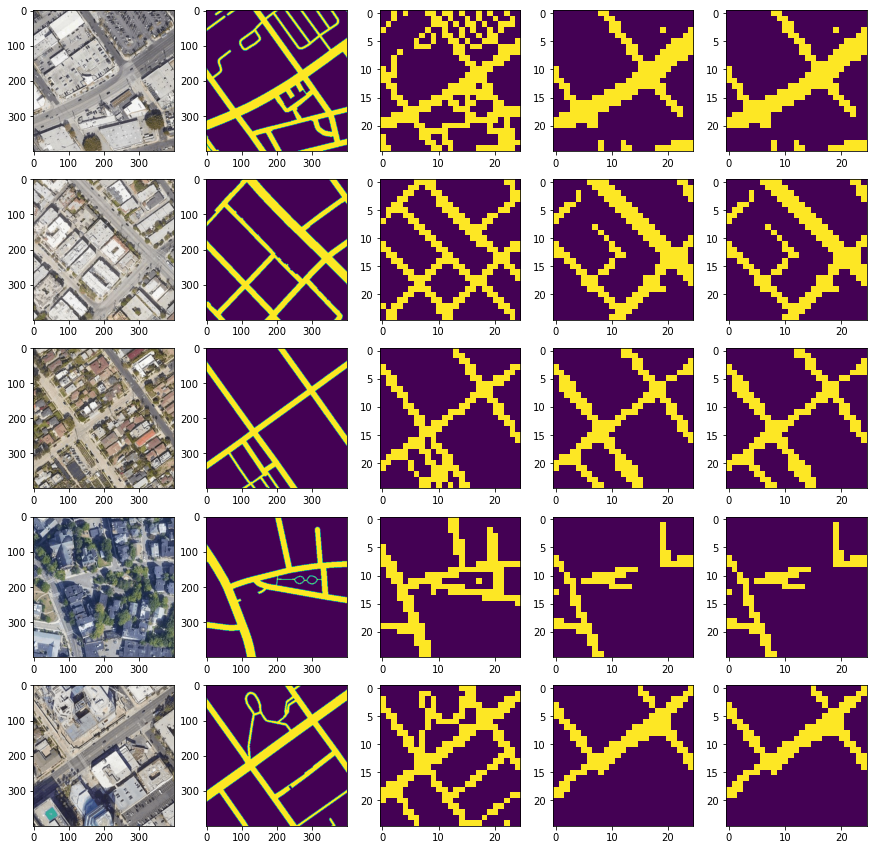

In [17]:
from PIL import Image

num_imgs = 5
offset = 2 * num_imgs

fig, ax = plt.subplots(num_imgs, 5, figsize=(15, 15))

for index in range(num_imgs):

    print(data_paths_val[index][0])
    print(label_paths_val[index])

    ax[index, 0].imshow(Image.open(data_paths_val[index + offset][0]))
    ax[index, 1].imshow(Image.open(label_paths_val[index + offset]))
    ax[index, 2].imshow(post(cv2.imread(label_paths_val[index + offset])).view(25, 25).numpy())
    #ax[index, 2].imshow(label_transf1(cv2.imread(label_paths_val[index + offset])).squeeze().numpy())
    #ax[index, 2].imshow(label_transf1(cv2.imread(label_paths_val[index + offset])).view((5, 5)).squeeze().numpy())

    print(val_dataset[index][0].shape)

    model.eval()
    with torch.no_grad():    
        pred = postprocess(model(val_dataset[index + offset][0].unsqueeze(0))).view(25, 25).numpy()
        ax[index, 3].imshow(pred)    
        ax[index, 4].imshow(pred.round())        
plt.show()

In [ ]:
with open("submission.csv", 'w') as f:
        f.write('id,prediction\n')   
        for path in test_paths: 
            img_number = int(path.split('_')[1].split('.')[0])
            print(img_number)
            data = cv2.imread(path)
            data = data_transf(data)
            pred = postprocess(model(data.unsqueeze(0))).view(25, 25).numpy()
            fig, ax = plt.subplots(1, 2, figsize=(15, 15))
            ax[0].imshow(data.permute(1, 2, 0))
            ax[1].imshow(pred)
            plt.show()
            for i in range(pred.shape[0]):
                for j in range(pred.shape[1]):
                    f.write("{:03d}_{}_{},{}\n".format(img_number, i*16, j*16, int(pred[i, j])))

# Inference

model.eval()
with torch.no_grad():
    preds = torch.tensor([])
    for data, _ in tqdm(val_loader, desc="Predicting"):
        data = data.to(device)
        out = model(data)#, clf=True)
        preds = torch.cat([preds, out.cpu().detach()], dim=0)

# Postprocessing

from utils.postprocess import masks_to_labels

predictions = masks_to_labels(preds)

print(predictions[:50])